In [136]:
#
# Copyright (c) 2021, NVIDIA CORPORATION. All rights reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
#

### Check the TensorRT version

In [137]:
!python3 -c 'import tensorrt; print("TensorRT version: {}".format(tensorrt.__version__))'

OSError: [Errno 12] Cannot allocate memory

### Import required modules

In [ ]:
import numpy as np
import os
import pycuda.driver as cuda
import pycuda.autoinit
import tensorrt as trt
import cv2
import torch

# import matplotlib.pyplot as plt
from PIL import Image

TRT_LOGGER = trt.Logger()

# Filenames of TensorRT plan file and input/output images.
engine_file = "unet_v1.trt"
input_file  = "9.png"
output_file = "test.png"

In [ ]:
def find_edge_channel(img):
    edges_mask = np.zeros((img.shape[0], img.shape[1]), dtype=np.uint8)
    width = img.shape[1]
    height = img.shape[0]

    gray_im = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # gray_im = cv2.GaussianBlur(gray_im,(3,3),0)
    # Separate into quadrants
    med1 = np.median(gray_im[: height // 2, : width // 2])
    med2 = np.median(gray_im[: height // 2, width // 2:])
    med3 = np.median(gray_im[height // 2:, width // 2:])
    med4 = np.median(gray_im[height // 2:, : width // 2])

    l1 = int(max(0, (1 - 0.205) * med1))
    u1 = int(min(255, (1 + 0.205) * med1))
    e1 = cv2.Canny(gray_im[: height // 2, : width // 2], l1, u1)

    l2 = int(max(0, (1 - 0.205) * med2))
    u2 = int(min(255, (1 + 0.205) * med2))
    e2 = cv2.Canny(gray_im[: height // 2, width // 2:], l2, u2)

    l3 = int(max(0, (1 - 0.205) * med3))
    u3 = int(min(255, (1 + 0.205) * med3))
    e3 = cv2.Canny(gray_im[height // 2:, width // 2:], l3, u3)

    l4 = int(max(0, (1 - 0.205) * med4))
    u4 = int(min(255, (1 + 0.205) * med4))
    e4 = cv2.Canny(gray_im[height // 2:, : width // 2], l4, u4)

    # Stitch the edges together
    edges_mask[: height // 2, : width // 2] = e1
    edges_mask[: height // 2, width // 2:] = e2
    edges_mask[height // 2:, width // 2:] = e3
    edges_mask[height // 2:, : width // 2] = e4

    edges_mask_inv = cv2.bitwise_not(edges_mask)

    return edges_mask, edges_mask_inv

### Utilities for input / output processing

In [ ]:
# For torchvision models, input images are loaded in to a range of [0, 1] and
# normalized using mean = [0.485, 0.456, 0.406] and stddev = [0.229, 0.224, 0.225].
def preprocess(image):
    # image = np.array(image)
    # frame_copy = np.copy(image)
    # gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # gradient_map = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=-1) # Gradient map along x
    # #         gradient_map = cv2.Laplacian(gray, cv2.CV_64F)
    # gradient_map = np.uint8(np.absolute(gradient_map))
    # test_edges, test_edges_inv = find_edge_channel(frame_copy)


    # frame_copy = np.zeros((gray.shape[0],gray.shape[1],4),dtype=np.uint8)
    # frame_copy[:,:,0] = gray
    # frame_copy[:,:,1] = test_edges
    # frame_copy[:,:,2] = test_edges_inv
    # frame_copy[:,:,3] = gradient_map
    # frame_copy = cv2.resize(frame_copy, (256, 160))

    # input = torch.Tensor(frame_copy.reshape(
    #     1, 4, 160, 256
    # ))


    # mean = np.array([0.485, 0.456, 0.406]).astype('float32')
    # stddev = np.array([0.229, 0.224, 0.225]).astype('float32')

    mean = np.array([1, 1, 1]).astype('float32')
    stddev = np.array([1, 1, 1]).astype('float32')
    data = (np.asarray(image).astype('float32')[:, :, :3] / float(1.0) - mean) / stddev
    # Switch from HWC to to CHW order
    # return np.moveaxis(data, 2, 0)
    te = np.copy(data)
    print(np.moveaxis(te, 2, 0).shape)
    return data

def postprocess(data):
    return data
    num_classes = 21
    # create a color palette, selecting a color for each class
    palette = np.array([2 ** 25 - 1, 2 ** 15 - 1, 2 ** 21 - 1])
    colors = np.array([palette*i%255 for i in range(num_classes)]).astype("uint8")
    # plot the segmentation predictions for 21 classes in different colors
    print(data.shape)
    img = Image.fromarray(data.astype('uint8'), mode='P')
    img.putpalette(colors)
    return img


### Load TensorRT engine

Deserialize the TensorRT engine from specified plan file. 

In [ ]:
def load_engine(engine_file_path):
    assert os.path.exists(engine_file_path)
    print("Reading engine from file {}".format(engine_file_path))
    with open(engine_file_path, "rb") as f, trt.Runtime(TRT_LOGGER) as runtime:
        return runtime.deserialize_cuda_engine(f.read())

### Inference pipeline

Starting with a deserialized engine, TensorRT inference pipeline consists of the following steps:
- Create an execution context and specify input shape (based on the image dimensions for inference).
- Allocate CUDA device memory for input and output.
- Allocate CUDA page-locked host memory to efficiently copy back the output.
- Transfer the processed image data into input memory using asynchronous host-to-device CUDA copy.
- Kickoff the TensorRT inference pipeline using the asynchronous execute API.
- Transfer the segmentation output back into pagelocked host memory using device-to-host CUDA copy.
- Synchronize the stream used for data transfers and inference execution to ensure all operations are completes.
- Finally, write out the segmentation output to an image file for visualization.

In [143]:
def infer(engine, input_file, output_file):
    print("Reading input image from file {}".format(input_file))
    with Image.open(input_file) as img:
        input_image = preprocess(img)
        # input_image = input_image.cpu().detach().numpy().astype(np.float32)
        # input_image = np.squeeze(input_image, axis=0).astype(np.float32)
        # print(input_image.shape)
        # input_image = Image.fromarray(input_image)

        image = np.array(input_image)
        frame_copy = np.copy(image)
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        gradient_map = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=-1) # Gradient map along x
        #         gradient_map = cv2.Laplacian(gray, cv2.CV_64F)
        gradient_map = np.uint8(np.absolute(gradient_map))
        test_edges, test_edges_inv = find_edge_channel(np.uint8(frame_copy))


        frame_copy = np.zeros((gray.shape[0],gray.shape[1],4),dtype=np.uint8)
        frame_copy[:,:,0] = gray
        frame_copy[:,:,1] = test_edges
        frame_copy[:,:,2] = test_edges_inv
        frame_copy[:,:,3] = gradient_map
        frame_copy = cv2.resize(frame_copy, (256, 160))


        input_image = (frame_copy / 255.).astype(np.float32)
        np.moveaxis(input_image, 2, 0)
        print(input_image.shape)

        image_width = input_image.shape[1]
        image_height = input_image.shape[0]

    with engine.create_execution_context() as context:
        # Set input shape based on image dimensions for inference
        context.set_binding_shape(engine.get_binding_index("input"), (1, 4, image_height, image_width))
        # Allocate host and device buffers
        bindings = []
        for binding in engine:
            binding_idx = engine.get_binding_index(binding)
            size = trt.volume(context.get_binding_shape(binding_idx))
            dtype = trt.nptype(engine.get_binding_dtype(binding))
            if engine.binding_is_input(binding):
                input_buffer = np.ascontiguousarray(input_image)
                input_memory = cuda.mem_alloc(input_image.nbytes)
                bindings.append(int(input_memory))
            else:
                output_buffer = cuda.pagelocked_empty(size, dtype)
                output_memory = cuda.mem_alloc(output_buffer.nbytes)
                bindings.append(int(output_memory))

        stream = cuda.Stream()
        # Transfer input data to the GPU.
        cuda.memcpy_htod_async(input_memory, input_buffer, stream)
        # Run inference
        context.execute_async_v2(bindings=bindings, stream_handle=stream.handle)
        # Transfer prediction output from the GPU.
        cuda.memcpy_dtoh_async(output_buffer, output_memory, stream)
        # Synchronize the stream
        stream.synchronize()

    out_img = np.reshape(output_buffer, (image_height, image_width))
    print("Writing output image to file {}".format(output_file))
    cv2.imwrite(output_file, out_img * -10)
    print(np.max(out_img))

    # with np.reshape(output_buffer, (image_height, image_width)) as img:
    #     print("Writing output image to file {}".format(output_file))
    #     # img.convert('RGB').save(output_file, "PNG")
    #     cv2.imwrite(output_file, img)

### Plot input image

In [ ]:
plt.imshow(Image.open(input_file))

NameError: name 'plt' is not defined

### Run inference

In [144]:
print("Running TensorRT inference for FCN-ResNet101")
with load_engine(engine_file) as engine:
    infer(engine, input_file, output_file)

Running TensorRT inference for FCN-ResNet101
Reading engine from file unet_v1.trt
Reading input image from file 9.png
(3, 360, 640)
(160, 256, 4)
Writing output image to file test.png
-5.717847


### Plot segmentation output

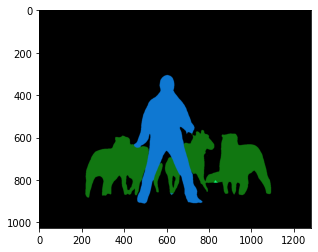

In [ ]:
plt.imshow(Image.open(output_file))